# Benchmarking do Código de Multiplicação de Matrizes
## Profa. Dra. Sarita Mazzini Bruschi

Alunos:
- Gabriel da Cunha Dertoni -
- Matheus Ventura de Sousa - 11345541
- Pedro Lucas de Moliner de Castro -
- Vitor

# 0. Preparando o Ambiente

In [1]:
import json
import pandas as pd
import numpy as np
import scipy as sc
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# If I run in colab
# Importing data
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p Data
!cp -r /content/drive/MyDrive/profiling.json /content/Data/

drive.flush_and_unmount()

ModuleNotFoundError: No module named 'google'

In [2]:
def my_enum(xs, start, step):
  for x in xs:
      yield (start, x)
      start += step
      
def pearson_for_dataframe(dataframe: pd.DataFrame, name_dataframe: str) -> None:
  fig, axes = plt.subplots(5, 2, figsize=(20, 20))

  x, y = 0, 0

  for i, col1 in enumerate(dataframe.columns):
    for j, col2 in enumerate(dataframe.columns):
      if i <= j:
        continue

      rho = sc.stats.pearsonr(dataframe[col1], dataframe[col2]).statistic

      axes[x][y].plot(dataframe[col1], dataframe[col2], '-o', color='red', markersize=10, linewidth=0, \
        markerfacecolor='lightgray', markeredgecolor='black',    \
        markeredgewidth=2)

      # determine best fit line
      par = np.polyfit(dataframe[col1], dataframe[col2], 1, full=True)
      slope = par[0][0]
      intercept = par[0][1]
      xl = [dataframe[col1].min(), dataframe[col1].max()]
      yl = [slope*xx + intercept for xx in xl]
      axes[x][y].plot(xl, yl, '--', linewidth=3, color='black', label=f"rho = {rho:.2f}")
      axes[x][y].legend()
      plt.xticks(fontsize=15)
      plt.yticks(fontsize=15)


      axes[x][y].set_xlabel(f"{col1}")
      axes[x][y].set_ylabel(f"{col2}")

      x = x+1 if y else x
      y = (y+1)%2


  fig.suptitle(f"Pearson correlation of {name_dataframe}")
  plt.show()

def build_box_plots(dataframe: pd.DataFrame, nome_figure: str) -> None:
  fig, axes = plt.subplots(3,2, figsize=(18,18))

  for i, col in enumerate(dataframe.columns):
    axes[i//2][i%2].hist(dataframe[col])
    axes[i//2][i%2].set_xlabel(f"Quantidade")
    axes[i//2][i%2].set_ylabel(f"Frequência")
    axes[i//2][i%2].set_title(f"{col}")

  fig.suptitle(nome_figure)
  plt.show()

# 1. Benchmarking

## 1.1. Getting Data

In [3]:
# prof_file = open('/content/Data/profiling.json', 'r') # If I run in colab
prof_file = open('./01/profiling.json', 'r') # If I run in local
prof_dict = json.load(prof_file)
prof_file.close()

prof_dict

FileNotFoundError: [Errno 2] No such file or directory: './01/profiling.json'

In [10]:
for i in range(len(prof_dict['data'])):
  prof_dict['data'][i]['measurements'] = pd.DataFrame(prof_dict['data'][i]['measurements'])

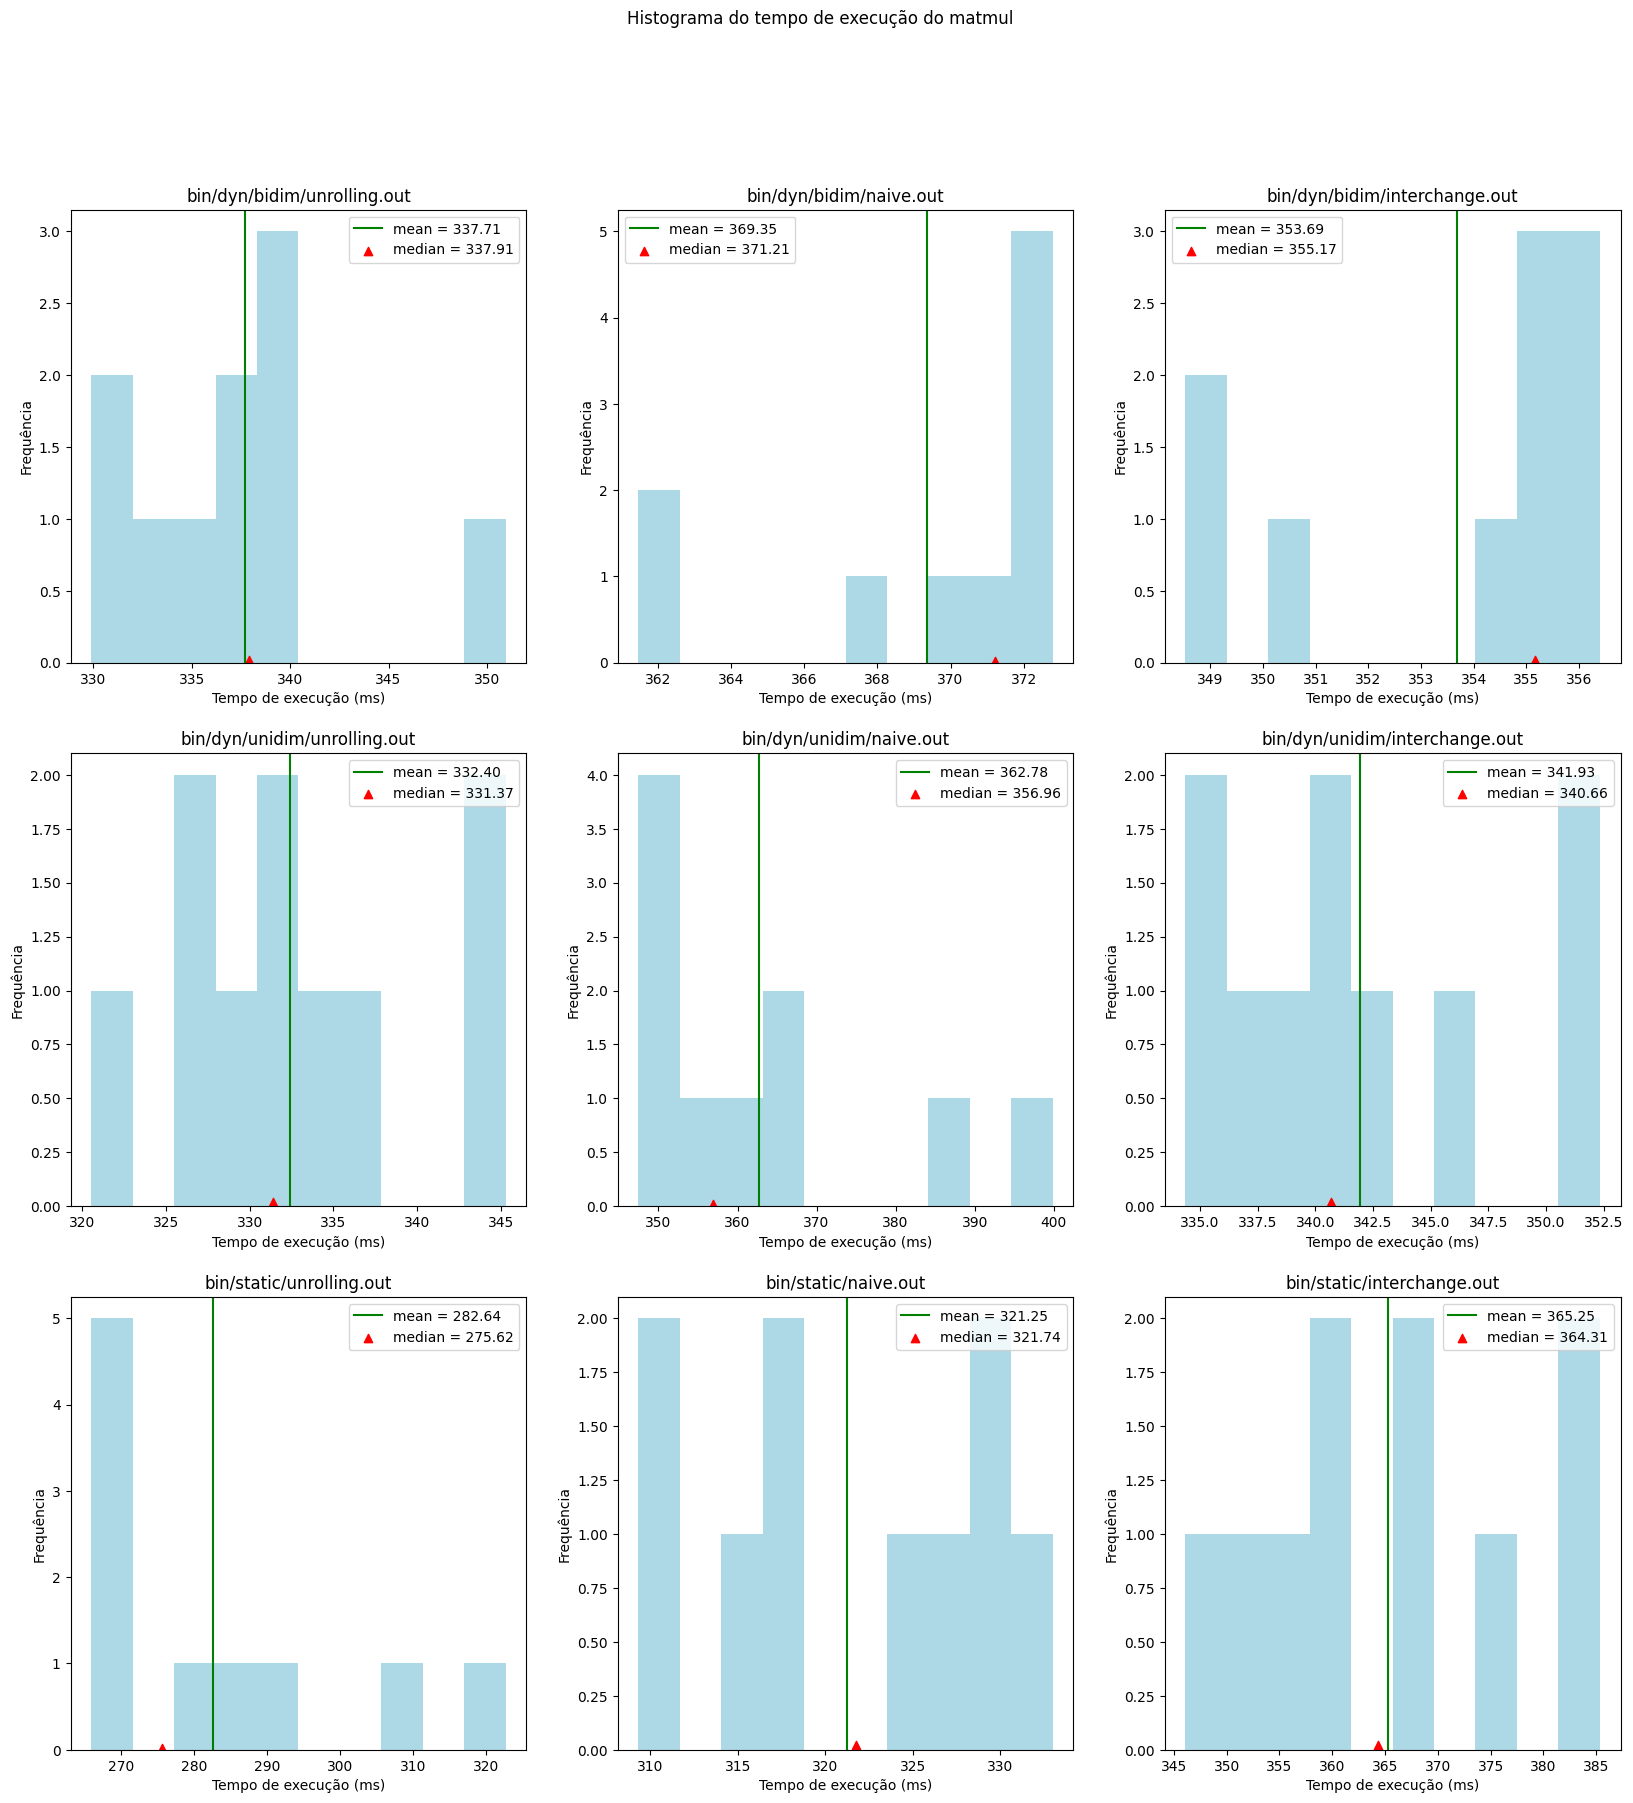

In [119]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for i, profilling in enumerate(prof_dict['data']):
  mean = profilling['measurements']['matmul'].mean()
  median = profilling['measurements']['matmul'].median()
  axes[i//3][i%3].hist(profilling['measurements']['matmul'], color='lightblue')
  axes[i//3][i%3].axvline(mean, color='green', label=f'mean = {mean:.2f}')
  axes[i//3][i%3].scatter(x=[median], y=[0.02], color='red', marker="^", label=f'median = {median:.2f}')
  axes[i//3][i%3].set_xlabel(f"Tempo de execução (ms)")
  axes[i//3][i%3].set_ylabel(f"Frequência")
  axes[i//3][i%3].set_title(f"{profilling['bin']}")
  axes[i//3][i%3].legend()

fig.suptitle("Histograma do tempo de execução do matmul")
plt.savefig("./graphics/matmul_hist.png")

std_hit_st = 7718.19
std_miss_st = 320836.51
std_hit_st = 5697.89
std_miss_st = 1256.15
std_hit_st = 11960.80
std_miss_st = 361456.70
std_hit_st = 37461.43
std_miss_st = 5778.68
std_hit_st = 124352.55
std_miss_st = 6785430.35
std_hit_st = 392171.57
std_miss_st = 43817.57


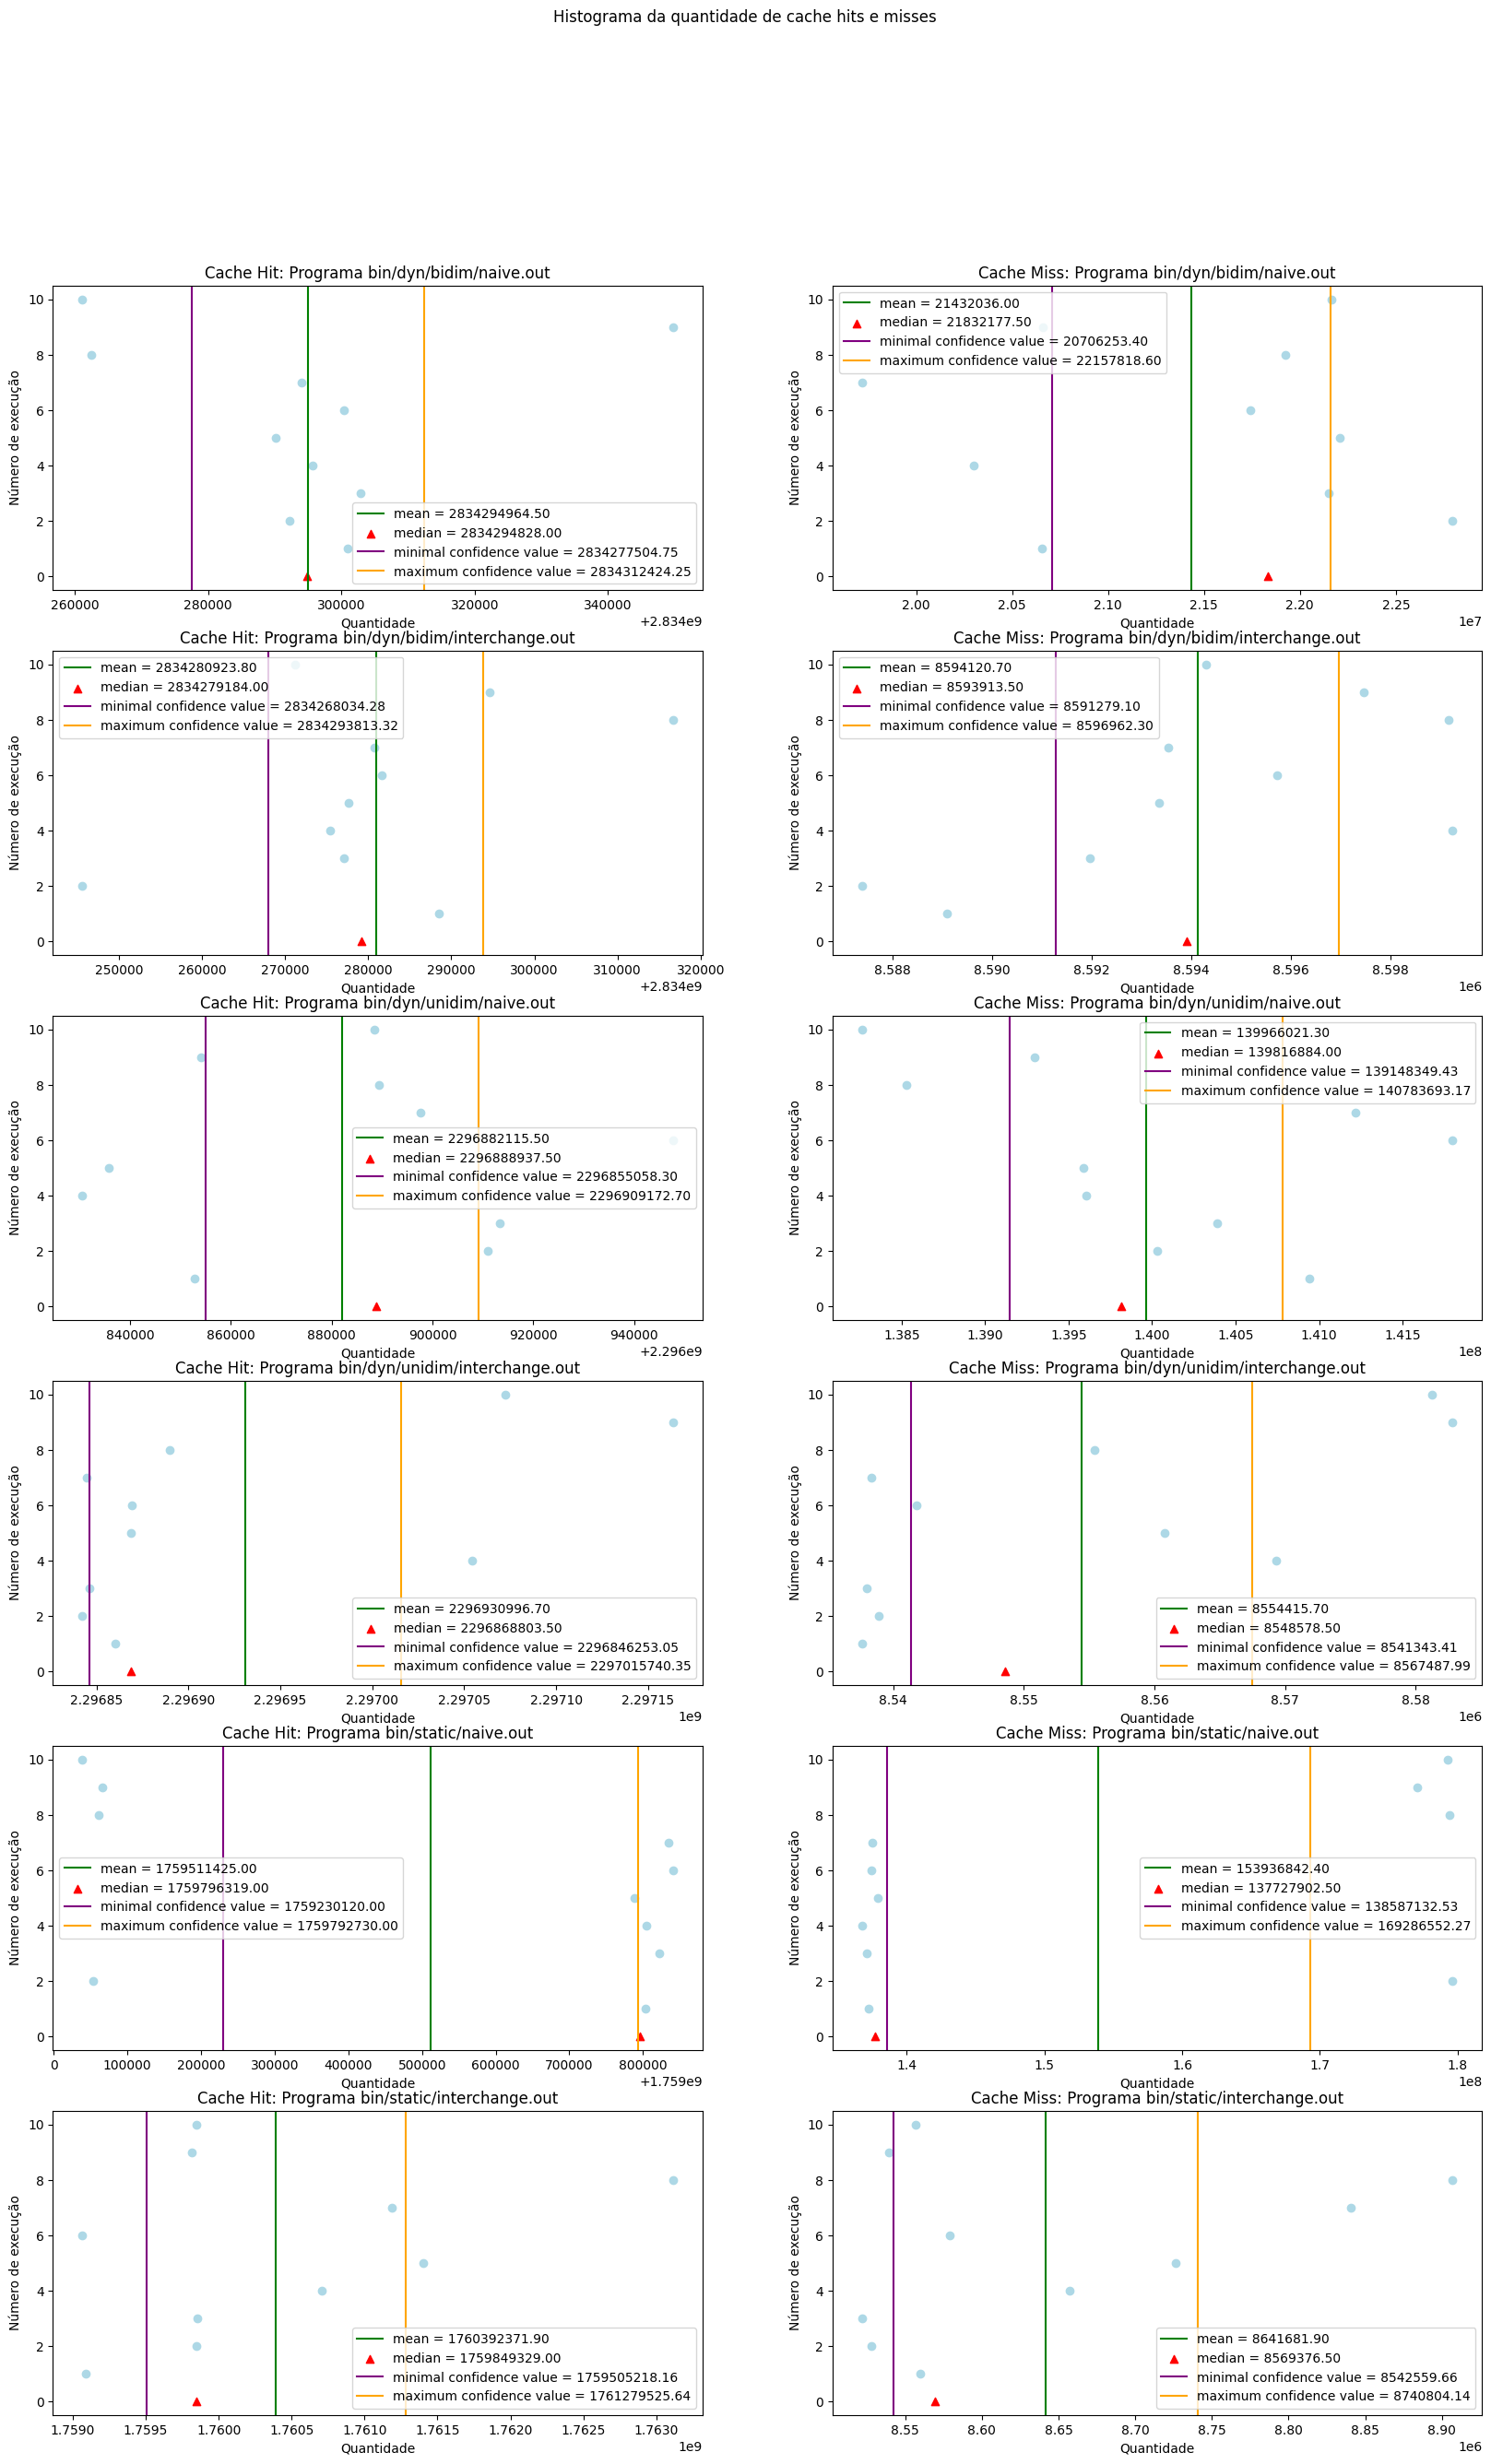

In [118]:
new_prof_dict = [profilling for profilling in prof_dict['data'] if profilling['bin'].find('interchange') != -1 or profilling['bin'].find('naive') != -1]
new_prof_dict

fig, axes = plt.subplots(len(new_prof_dict), 2, figsize=(20, 30))

# Confidence interval coefficient
alpha = 0.95

for i in range(len(new_prof_dict)):

  mean_hit = new_prof_dict[i]['measurements']['L1-dcache-loads'].mean()
  median_hit = new_prof_dict[i]['measurements']['L1-dcache-loads'].median()
  std_hit_st = st.sem(new_prof_dict[i]['measurements']['L1-dcache-loads'])

  print(f"std_hit_st = {std_hit_st:.2f}")

  ci_hit = st.t.interval(alpha, len(new_prof_dict[0]['measurements']['L1-dcache-loads'])-1, loc=mean_hit, scale=std_hit_st)

  mean_miss = new_prof_dict[i]['measurements']['L1-dcache-load-misses'].mean()
  median_miss = new_prof_dict[i]['measurements']['L1-dcache-load-misses'].median()
  std_miss_st = st.sem(new_prof_dict[i]['measurements']['L1-dcache-load-misses'])
  ci_miss = st.t.interval(alpha, len(new_prof_dict[0]['measurements']['L1-dcache-load-misses'])-1, loc=mean_miss, scale=std_miss_st)

  print(f"std_miss_st = {std_miss_st:.2f}")

  axes[i][0].scatter(x=new_prof_dict[i]['measurements']['L1-dcache-loads'], y=np.arange(1, new_prof_dict[i]['measurements']['L1-dcache-loads'].shape[0]+1), color='lightblue')
  axes[i][0].axvline(mean_hit, color='green', label=f'mean = {mean_hit:.2f}')
  axes[i][0].scatter(x=[median_hit], y=[0.02], color='red', marker="^", label=f'median = {median_hit:.2f}')
  axes[i][0].axvline(ci_hit[0], color='purple', label=f'minimal confidence value = {ci_hit[0]:.2f}')
  axes[i][0].axvline(ci_hit[1], color='orange', label=f'maximum confidence value = {ci_hit[1]:.2f}')
  axes[i][0].set_xlabel(f"Quantidade")
  axes[i][0].set_ylabel(f"Número de execução")
  axes[i][0].set_title(f"Cache Hit: Programa {new_prof_dict[i]['bin']}")
  axes[i][0].legend()

  axes[i][1].scatter(x=new_prof_dict[i]['measurements']['L1-dcache-load-misses'], y=np.arange(1, new_prof_dict[i]['measurements']['L1-dcache-load-misses'].shape[0]+1), color='lightblue')
  axes[i][1].axvline(mean_miss, color='green', label=f'mean = {mean_miss:.2f}')
  axes[i][1].scatter(x=[median_miss], y=[0.02], color='red', marker="^", label=f'median = {median_miss:.2f}')
  axes[i][1].axvline(ci_miss[0], color='purple', label=f'minimal confidence value = {ci_miss[0]:.2f}')
  axes[i][1].axvline(ci_miss[1], color='orange', label=f'maximum confidence value = {ci_miss[1]:.2f}')
  axes[i][1].set_xlabel(f"Quantidade")
  axes[i][1].set_ylabel(f"Número de execução")
  axes[i][1].set_title(f"Cache Miss: Programa {new_prof_dict[i]['bin']}")
  axes[i][1].legend()

fig.suptitle("Histograma da quantidade de cache hits e misses")
plt.savefig("./graphics/cache_hits_misses.png")

std_hit_st = 5372.34
std_miss_st = 20207.16
std_hit_st = 5473.40
std_miss_st = 118.64
std_hit_st = 5946.93
std_miss_st = 10013.10
std_hit_st = 9364.31
std_miss_st = 845.37
std_hit_st = 105572.03
std_miss_st = 11876.08
std_hit_st = 92729.85
std_miss_st = 4990.91


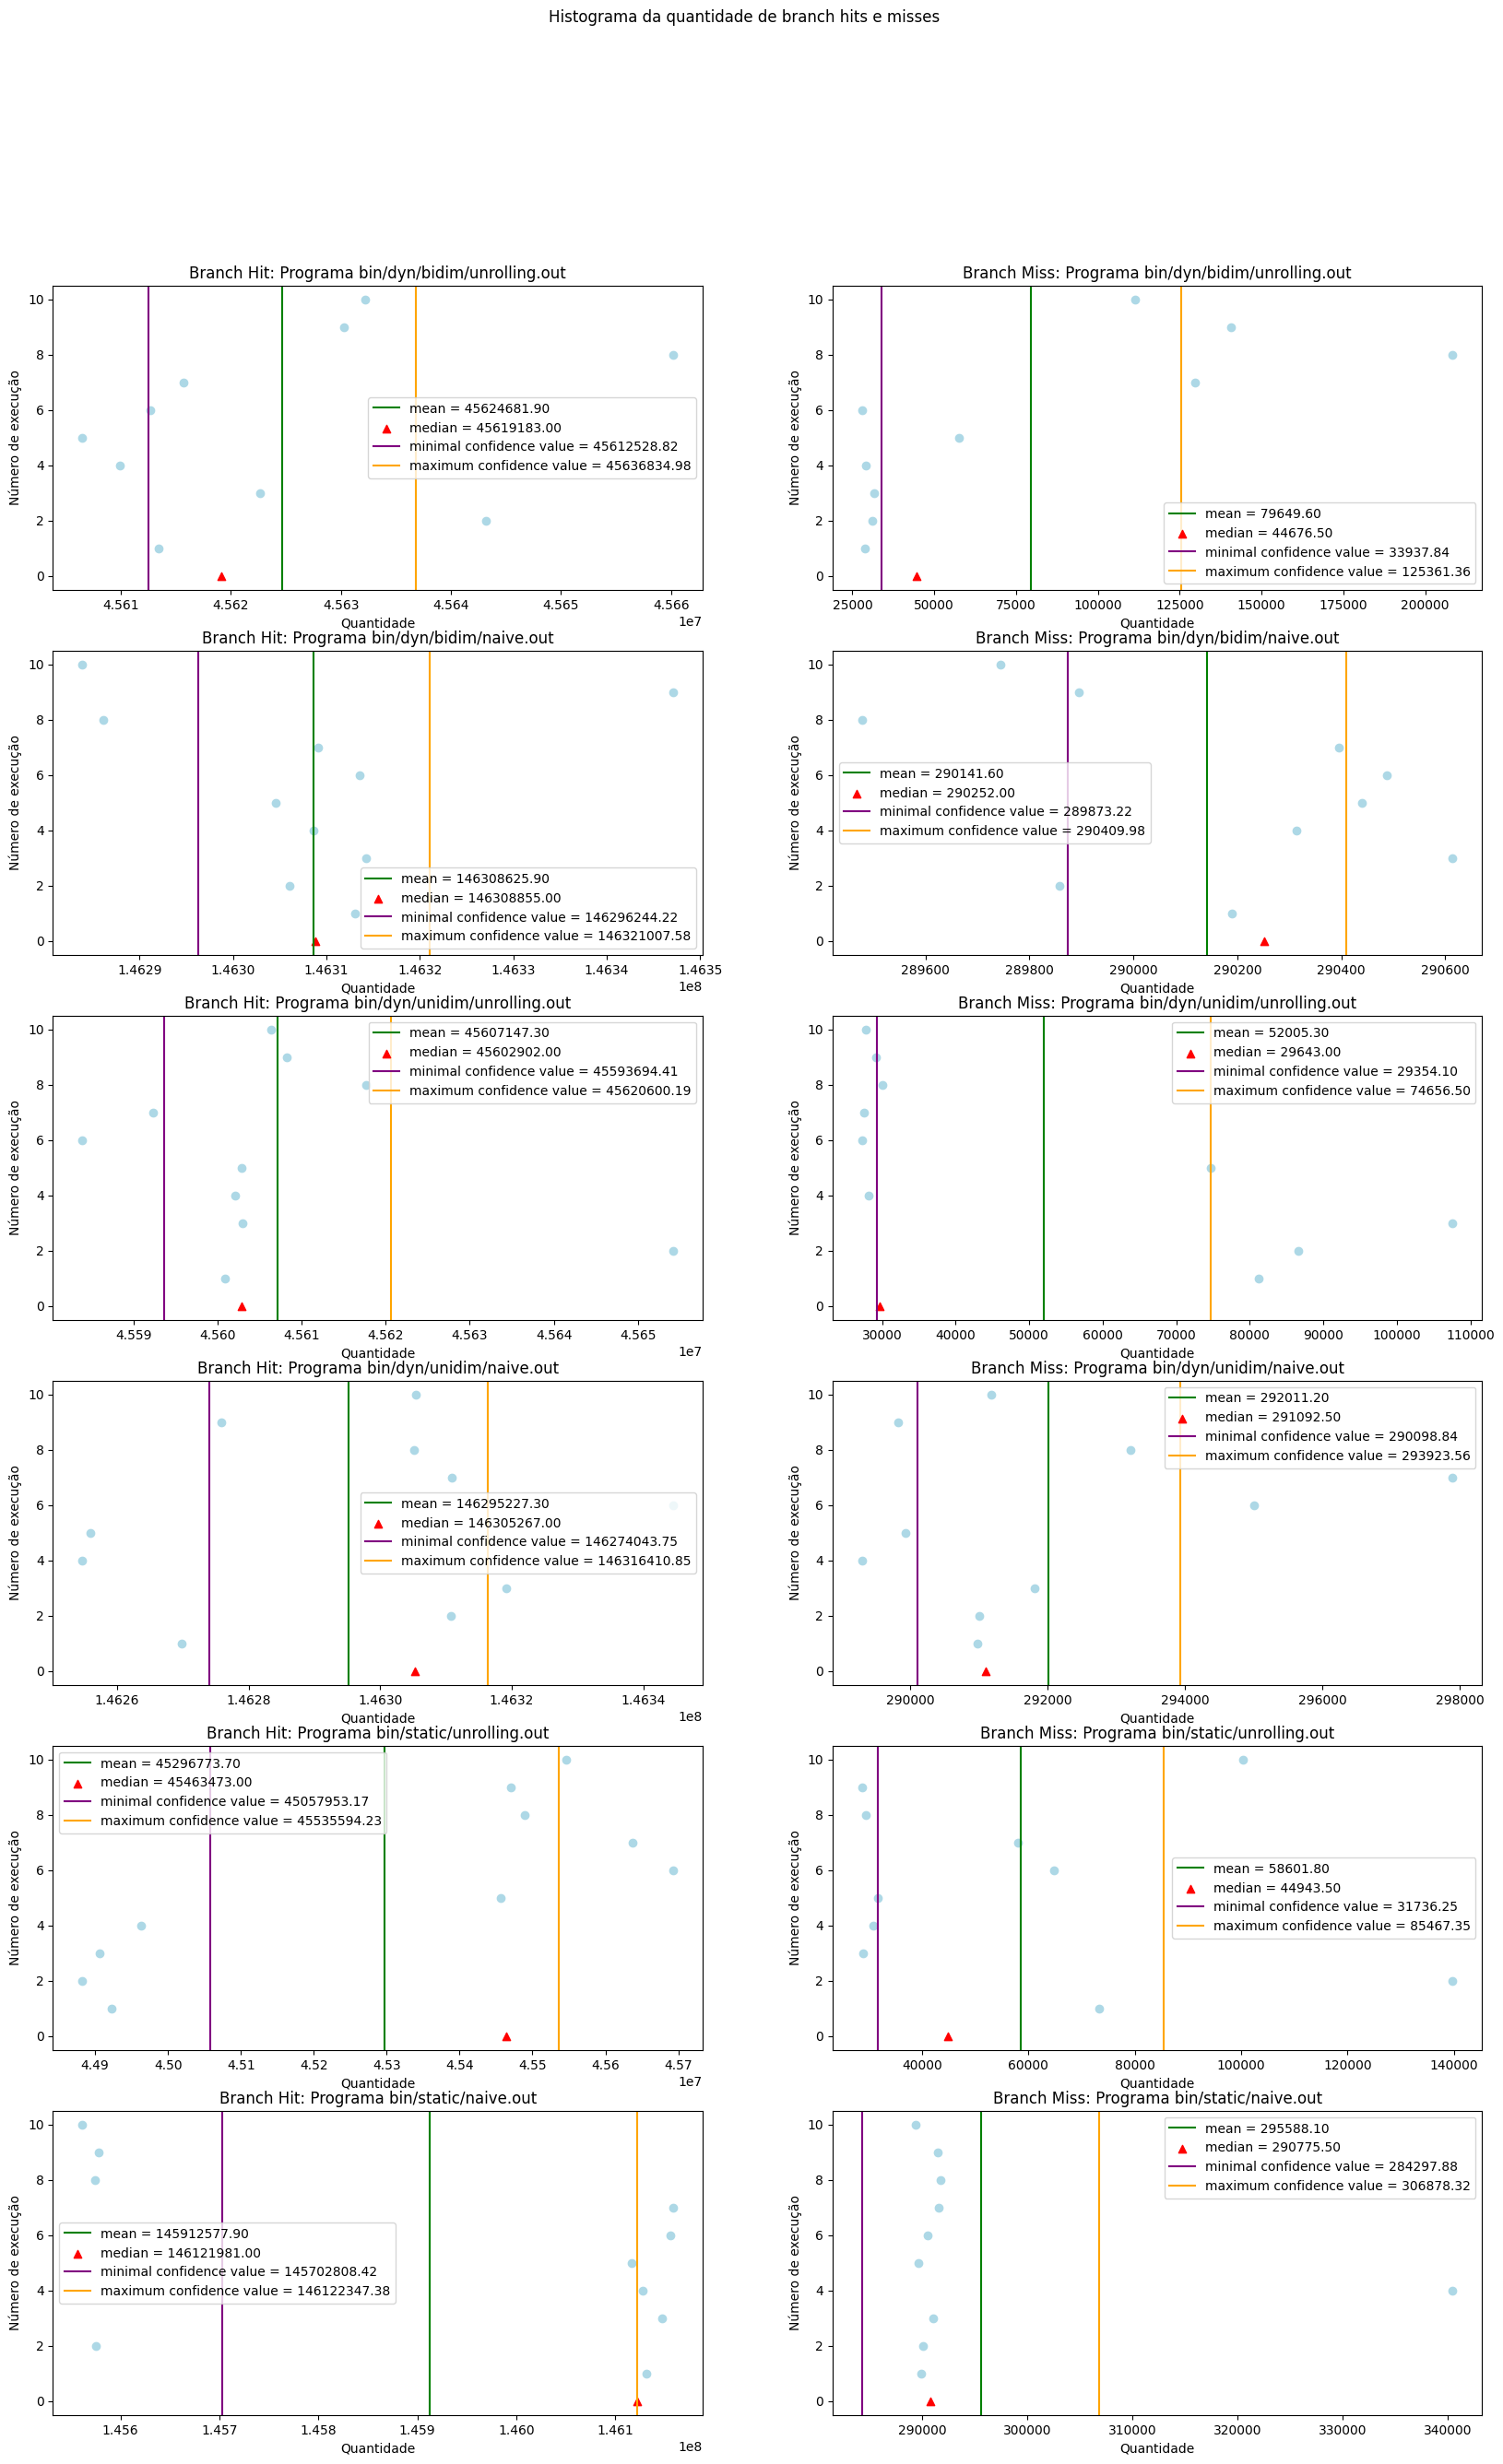

In [117]:
new_prof_dict = [profilling for profilling in prof_dict['data'] if profilling['bin'].find('unrolling') != -1 or profilling['bin'].find('naive') != -1]
new_prof_dict

fig, axes = plt.subplots(len(new_prof_dict), 2, figsize=(20, 30))

# Confidence interval coefficient
alpha = 0.95

for i in range(len(new_prof_dict)):

  mean_hit = new_prof_dict[i]['measurements']['branch-instructions'].mean()
  median_hit = new_prof_dict[i]['measurements']['branch-instructions'].median()
  std_hit_st = st.sem(new_prof_dict[i]['measurements']['branch-instructions'])

  print(f"std_hit_st = {std_hit_st:.2f}")

  ci_hit = st.t.interval(alpha, len(new_prof_dict[0]['measurements']['branch-instructions'])-1, loc=mean_hit, scale=std_hit_st)

  mean_miss = new_prof_dict[i]['measurements']['branch-misses'].mean()
  median_miss = new_prof_dict[i]['measurements']['branch-misses'].median()
  std_miss_st = st.sem(new_prof_dict[i]['measurements']['branch-misses'])
  ci_miss = st.t.interval(alpha, len(new_prof_dict[0]['measurements']['branch-misses'])-1, loc=mean_miss, scale=std_miss_st)

  print(f"std_miss_st = {std_miss_st:.2f}")

  axes[i][0].scatter(x=new_prof_dict[i]['measurements']['branch-instructions'], y=np.arange(1, new_prof_dict[i]['measurements']['branch-instructions'].shape[0]+1), color='lightblue')
  axes[i][0].axvline(mean_hit, color='green', label=f'mean = {mean_hit:.2f}')
  axes[i][0].scatter(x=[median_hit], y=[0], color='red', marker="^", label=f'median = {median_hit:.2f}')
  axes[i][0].axvline(ci_hit[0], color='purple', label=f'minimal confidence value = {ci_hit[0]:.2f}')
  axes[i][0].axvline(ci_hit[1], color='orange', label=f'maximum confidence value = {ci_hit[1]:.2f}')
  axes[i][0].set_xlabel(f"Quantidade")
  axes[i][0].set_ylabel(f"Número de execução")
  axes[i][0].set_title(f"Branch Hit: Programa {new_prof_dict[i]['bin']}")
  axes[i][0].legend()

  axes[i][1].scatter(x=new_prof_dict[i]['measurements']['branch-misses'], y=np.arange(1, new_prof_dict[i]['measurements']['branch-misses'].shape[0]+1), color='lightblue')
  axes[i][1].axvline(mean_miss, color='green', label=f'mean = {mean_miss:.2f}')
  axes[i][1].scatter(x=[median_miss], y=[0], color='red', marker="^", label=f'median = {median_miss:.2f}')
  axes[i][1].axvline(ci_miss[0], color='purple', label=f'minimal confidence value = {ci_miss[0]:.2f}')
  axes[i][1].axvline(ci_miss[1], color='orange', label=f'maximum confidence value = {ci_miss[1]:.2f}')
  axes[i][1].set_xlabel(f"Quantidade")
  axes[i][1].set_ylabel(f"Número de execução")
  axes[i][1].set_title(f"Branch Miss: Programa {new_prof_dict[i]['bin']}")
  axes[i][1].legend()

fig.suptitle("Histograma da quantidade de branch hits e misses")
plt.savefig("./graphics/branch_hits_misses.png")